## Performance Benchmarks

In [4]:
import tenseal as ts
import sqlite3
import os

In [15]:
# First let us create the CKKS Keys:
# Make sure that the keys are not overwritten 
# as its used to encrypt the votes!


if not os.path.exists('../keys/privateKey_ckks.hex'):
    context_ckks = ts.context(
                scheme=ts.SCHEME_TYPE.CKKS,
                poly_modulus_degree=8192,
                coeff_mod_bit_sizes=[60,40,40,60]
            )
    context_ckks.global_scale = 2**40
    
    #create a ckks encrypted vector
    v1 = [0, 1, 2, 3, 4]
    enc_v1 = ts.ckks_vector(context_ckks, v1)

    serializedContextPrivate = context_ckks.serialize(save_secret_key=True)

    scprivate_hex = serializedContextPrivate.hex()

    #make context public
    context_ckks.make_context_public()

    serializedPublicContext = context_ckks.serialize()
    scpublic_hex = serializedPublicContext.hex()

    #write keys to file
    f = open("../keys/privateKey_ckks.hex", "w")
    f.write(scprivate_hex)
    f = open("../keys/publicKey_ckks.hex", "w")
    f.write(scprivate_hex)

    f.close()




In [ ]:
'''
The following code is to generate the keys for BFV
but we will not be running it since we have already created the KEY PAIRS for BFV

if not os.path.exists('../keys/privateKey_bfv.hex'):
    context_bfv = ts.context(ts.SCHEME_TYPE.BFV, poly_modulus_degree=4096, plain_modulus=18669569)

    serializedContextPrivate = context_bfv.serialize(save_secret_key=True)

    scprivate_hex = serializedContextPrivate.hex()

    #make context public
    context_bfv.make_context_public()

    serializedPublicContext = context_bfv.serialize()
    scpublic_hex = serializedPublicContext.hex()

    #write keys to file
    f = open("../keys/privateKey_bfv.hex", "w")
    f.write(scprivate_hex)
    f = open("../keys/publicKey_bfv.hex", "w")
    f.write(scprivate_hex)

    f.close()

'''

Let's us now mock 10000 votes and see how the 
performance compares between BVF and CKKS

In [230]:
import random

mockVotesRaw = []
for i in random.sample(range(100001,999999),10000):
    lrandom =  [i,0,0,0]
    lrandom[random.randint(1,3)] = 1  

    mockVotesRaw.append( lrandom )

mockVotesRaw.__len__()


10000

In [231]:
list_of_ckks_vectors = []

list_of_bfv_vectors = []



# Let us now read the CKKS Context from the KEY File:
with open('../keys/privateKey_ckks.hex', 'r') as f:
    ckks_context= ts.context_from(bytes.fromhex(f.read()))

# Similarly, let us read the BFV Context from the KEY File:
with open('../keys/privateKey_bfv.hex', 'r') as f1:
    bfv_context= ts.context_from(bytes.fromhex(f1.read()))

for mv in mockVotesRaw:
    #Let's now create the encrypted vectors for CKKS and BFV
    list_of_ckks_vectors.append(ts.ckks_vector(ckks_context, mv))
    list_of_bfv_vectors.append(ts.bfv_vector(bfv_context, mv))




In [261]:
# Function to decrypt each VOTE and count the votes for CKKS

def ckks_vote_tally(list_of_ckks_vectors, ckks_secret_key: ts.Context.secret_key):

    sum_votes = [0,0,0,0]

    for vote in list_of_ckks_vectors:
        # dec_vote = [ round(rv) for rv in vote.decrypt(ckks_secret_key)[1:]]
        # result = [list1[i] + list2[i] for i in range(len(small_list))]  #list(map(add, list1, list2)) 
        # print(dec_vote)
        sum_votes = sum_votes + vote 
    
    counted_result = [ round(rv) for rv in sum_votes.decrypt(ckks_secret_key)[1:]]


    print("[*] CKKS VOTE TALLY:", counted_result)

    max_index = counted_result.index(max(counted_result))+1


    if counted_result.count(max(counted_result)) == 1:
        print(f"[*] The Winner is: Candidate#{max_index}")

    else:
        print("[*] There is a tie!")
    

In [262]:
def bfv_vote_tally(list_of_bfv_vectors, bfv_secret_key: ts.Context.secret_key):

    sum_votes = [0,0,0,0]

    for vote in list_of_bfv_vectors:
        sum_votes = sum_votes + vote 
    
    counted_result = sum_votes.decrypt(bfv_secret_key)[1:]


    print("[*] BFV VOTE TALLY:", counted_result)

    max_index = counted_result.index(max(counted_result))+1

    if counted_result.count(max(counted_result)) == 1:
        print(f"[*] The Winner is: Candidate#{max_index}")

    else:
        print("[*] There is a tie!")

In [263]:
def normal_list_tally(mockVotesRaw):

    sum_votes = [0,0,0,0]
    for r in mockVotesRaw:
        sum_votes = [sum_votes[i] + r[i] for i in range(4)]
    counted_result = sum_votes[1:]
    print("[*] Normal VOTE TALLY:", counted_result)
    max_index = counted_result.index(max(counted_result))+1

    if counted_result.count(max(counted_result)) == 1:
        print(f"[*] The Winner is: Candidate#{max_index}")

    else:
        print("[*] There is a tie!")

In [245]:
ckks_vote_tally(list_of_ckks_vectors, ckks_context.secret_key())
# type(ckks_context.secret_key)
# [ round(r) for r in list_of_ckks_vectors[0].decrypt(ckks_context.secret_key())[1:] ]

[*] CKKS VOTE TALLY: [3278, 3408, 3314]
[*] The Winner is: Candidate#2


In [246]:
bfv_vote_tally(list_of_bfv_vectors, bfv_context.secret_key())

[*] BFV VOTE TALLY: [3278, 3408, 3314]
[*] The Winner is: Candidate#2


In [247]:
normal_list_tally(mockVotesRaw)

[*] Normal VOTE TALLY: [3278, 3408, 3314]
[*] The Winner is: Candidate#2


### Performance Statistics

In [264]:
import time

exec_times = []
# Measure execution time for function1
start_time = time.time()
ckks_vote_tally(list_of_ckks_vectors, ckks_context.secret_key())
end_time = time.time()
execution_time = (end_time - start_time) * 1000
exec_times.append(execution_time)


start_time = time.time()
bfv_vote_tally(list_of_bfv_vectors, bfv_context.secret_key())
end_time = time.time()
execution_time = (end_time - start_time) * 1000
exec_times.append(execution_time)


start_time = time.time()
normal_list_tally(mockVotesRaw)
end_time = time.time()
execution_time = (end_time - start_time) * 1000
exec_times.append(execution_time)

print("\nCKKS Tally Execution time:", exec_times[0], "ms")
print("BFV Tally Execution time:", exec_times[1], "ms")
print("Normal Tally Execution time:", exec_times[2], "ms")

[*] CKKS VOTE TALLY: [3278, 3408, 3314]
[*] The Winner is: Candidate#2
[*] BFV VOTE TALLY: [3278, 3408, 3314]
[*] The Winner is: Candidate#2
[*] Normal VOTE TALLY: [3278, 3408, 3314]
[*] The Winner is: Candidate#2

CKKS Tally Execution time: 1000.8838176727295 ms
BFV Tally Execution time: 464.5400047302246 ms
Normal Tally Execution time: 3.8368701934814453 ms


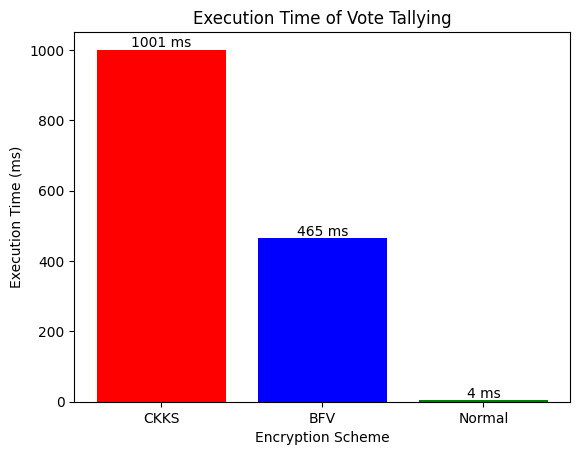

: 

In [265]:
#Plot
import matplotlib.pyplot as plt

# List of function names
labels = ["CKKS", "BFV", "Normal"]

# Plot the execution times
# plt.bar(labels, exec_times, color=['red','blue','green'])
bars = plt.bar(labels, exec_times, color=['red','blue','green'])

# Add labels and title
plt.xlabel('Encryption Scheme')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time of Vote Tallying')

# Overlay execution times on the bars
for bar, time in zip(bars, exec_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{round(time)} ms', ha='center', va='bottom')

# Display the plot
plt.show()